In [1]:
from collections import defaultdict, deque
from difflib import SequenceMatcher

import bblfsh
import Levenshtein
import pandas as pd
from sqlite3 import connect
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import text as plt_text


sns.set(style="ticks")
client = bblfsh.BblfshClient("0.0.0.0:9432")
%matplotlib inline

## Location of database

In [2]:
file_name = "2018-03-23T09_21_43Z-export.db"
print(file_name)

2018-03-23T09_21_43Z-export.db


## Query database

In [3]:
def to_str(string):
    return bytes(string)

user_id = {"Waren": 2,
           "Romain": 7,
           "Egor": 12}

query_answers = "select pair_id, user_id, answer from assignments where answer is not null and user_id in (2,7, 12);"
query_pairs = "select id as pair_id, content_a, content_b, score from file_pairs;"
with connect(file_name) as conn:    
    df = pd.read_sql_query(query_answers, conn)
    conn.text_factory = to_str  # super strange that it doesn't work with just str
    df_pairs = pd.read_sql_query(query_pairs, conn)

df_war = df[df.user_id == user_id["Waren"]]
df_rom = df[df.user_id == user_id["Romain"]]
df_eg = df[df.user_id == user_id["Egor"]]

## Calculate similarity score between texts and flatten UAST

In [4]:
client = bblfsh.BblfshClient("0.0.0.0:9432")

# Use it while there are some issues with bblfsh
def uast2sequence(root):
    sequence = []
    nodes = defaultdict(deque)
    stack = [root]
    nodes[id(root)].extend(root.children)
    while stack:
        if nodes[id(stack[-1])]:
            child = nodes[id(stack[-1])].popleft()
            nodes[id(child)].extend(child.children)
            stack.append(child)
        else:
            sequence.append(stack.pop())
    return sequence

def flatten_uast(uast):
    seq = uast2sequence(uast)
    res = [item.internal_type for item in seq]
    return res


def uast_to_type_seq(content):
    try:
        uast = client.parse(filename="java.java", contents=content).uast
    except:
        uast = client.parse(filename="java.java", contents=content.decode("utf-8", "ignore")).uast
    return flatten_uast(uast)


def ration_levenshtein(seq_a, seq_b):
    return Levenshtein.ratio(seq_a, seq_b)


def ratio_difflib(seq_a, seq_b):
    res = SequenceMatcher(None, seq_a, seq_b).ratio()
    # Dirty hack to avoid strange scores from DiffLib
    return max(res, SequenceMatcher(None, seq_b, seq_a).ratio())

    
def calc_uast_sim(row):
    content_a, content_b = row.content_a, row.content_b
    type_seq_a = uast_to_type_seq(bytes(content_a))
    type_seq_b = uast_to_type_seq(bytes(content_b))
    
    res = ration_levenshtein("".join(type_seq_a), "".join(type_seq_b))
    res_c = ration_levenshtein(content_a, content_b)
    
    return res, res_c

In [5]:
# similarity_scores = [calc_uast_sim(row) for _, row in tqdm(list(df_pairs.iterrows()))]
similarity_scores = []
for _, row in tqdm(list(df_pairs.iterrows())):
    try:
        similarity_scores.append(calc_uast_sim(row))
    except Exception as e:
        import pdb;pdb.set_trace()
        similarity_scores.append((0.5, 0.5))

df_pairs["uast_score"] = [pair_score[0] for pair_score in similarity_scores]
df_pairs["text_score"] = [pair_score[1] for pair_score in similarity_scores]

HBox(children=(IntProgress(value=0, max=1989), HTML(value='')))

## Assemble dataframe

In [6]:
df_war_pairs = df_pairs.join(df_war[["pair_id", "answer"]].set_index("pair_id"), on="pair_id", lsuffix="_as",
                             rsuffix="_war")
df_rom_war_pairs = df_war_pairs.join(df_rom[["pair_id", "answer"]].set_index("pair_id"), on="pair_id",
                                     lsuffix="_war", rsuffix="_rom")
df_eg_rom_war_pairs = df_rom_war_pairs.join(df_eg[["pair_id", "answer"]].set_index("pair_id"), on="pair_id")
df_eg_rom_war_pairs.columns = [col if col != "answer" else "answer_eg" for col in df_eg_rom_war_pairs.columns]

In [7]:
df_eg_rom_war_pairs[df_eg_rom_war_pairs["pair_id"]==964]["answer_eg"]

963    maybe
Name: answer_eg, dtype: object

## Plot infographics

In [8]:
def pairplot_df(df, columns, hue=None, hue_order=None):
    sns.pairplot(df[columns], hue=hue, hue_order=hue_order, diag_kind="kde")

In [9]:
columns = ["text_score", "uast_score"]
hue_order = ["yes", "maybe", "no"]

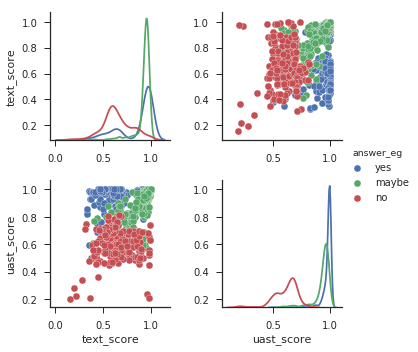

In [10]:
pairplot_df(df_eg_rom_war_pairs, columns + ["answer_eg"], hue="answer_eg", hue_order=hue_order)

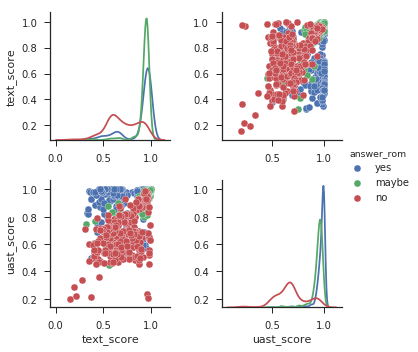

In [11]:
pairplot_df(df_eg_rom_war_pairs, columns + ["answer_rom"], hue="answer_rom", hue_order=hue_order)

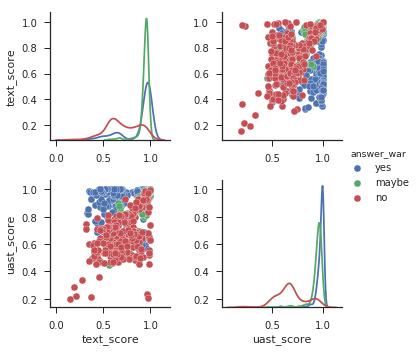

In [12]:
pairplot_df(df_eg_rom_war_pairs, columns + ["answer_war"], hue="answer_war", hue_order=hue_order)

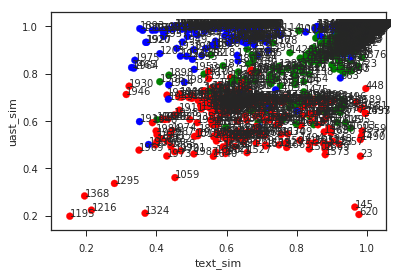

In [14]:
fig, ax = plt.subplots()
x = np.array(df_eg_rom_war_pairs["text_score"].tolist())
y = np.array(df_eg_rom_war_pairs["uast_score"].tolist())
col_map = {"yes": "b", "maybe": "g", "no": "r", None: "y"}
colors = np.array([col_map[ans]  for ans in df_eg_rom_war_pairs["answer_eg"].tolist()])
ax.scatter(x, y, c=colors)
ax.set_xlabel("text_sim")
ax.set_ylabel("uast_sim")


pair_ids = df_eg_rom_war_pairs["pair_id"].tolist()
for i, pair_id in enumerate(pair_ids):
    ax.annotate(pair_id, (x[i],y[i]))

## Sampling strategy

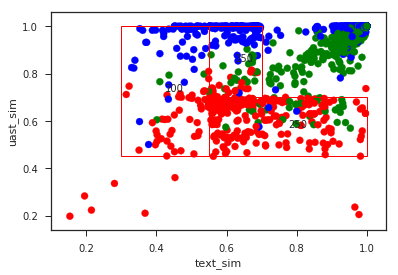

In [15]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=colors)
ax.set_xlabel("text_sim")
ax.set_ylabel("uast_sim")

def add_sampling_area(image, xy, width, height, text):
    rect = patches.Rectangle(xy, width, height, linewidth=1, edgecolor='r', facecolor='none')
    image.add_patch(rect)
    plt_text(xy[0] + width / 2, xy[1] + height / 2, text)

add_sampling_area(ax, (0.55, 0.45), 0.45, 0.25, "250")
add_sampling_area(ax, (0.55, 0.7), 0.15, 0.3, "150")
add_sampling_area(ax, (0.3, 0.45), 0.25, 0.55, "100")